# Predictiong biochemical activity against 2c9 with a small dataset

In this notebook we will try to use the more representative features of the Morgan fingerprint and the physicochemical descriptors given by Mordred library to fit a model with small dataset.


## Overview

- Load data
- Get fingerprint (in this case we simply load it from files)
- Get descriptors
- Select data


## 1) Packages

In [1]:
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from mordred import Calculator, descriptors

plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
print(tf.__version__)

load_clean_data =  True # Otherwise it will load data with NaN

2.0.0


## 2) Loading data

In [2]:
PATH_DATA = "../datasets/CYP/"

shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
def col_to_array(df, col_name='p450-cyp2c9 Activity Outcome'):
    col = df[col_name]
    arr = col.to_numpy() # class wants to make reference to active or inactive
    arr = np.reshape(arr, [arr.shape[0],1])
    return np.squeeze(arr)

In [4]:
smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')

## 3) Getting Mordred descriptors

We generate the descriptors using Mordred if ther are not in the features folder, otherwise the data is loaded from there.

There are two types of data we can load:

- Data without processing: this contains all the physicochemical descriptors that are generated with Mordred.
- Clean data: this data doesn't contains all the descriptors computed by Mordred. All the columns wich contain NaN, are remove to easily apply the feature selection.
    - This data has been processed as follows:
        - Convert all the str in the data frame to NaN.
        - Remove columns that contain NaN values.
            - Note that if we remove rows, we obtain an empty df (-> everything is removed)
        - Remove the all the columns with different headers between the shared and only 2c9 datasets.

In [5]:
def get_descriptors(smi_arr, activity_labels, clean_dataset=True, save_to_npy=True, filename='shared_set_features_mordred'):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in smi_arr]
    df_descriptors = calc.pandas(mols)
    df_descriptors = df_descriptors.insert(0, "p450-cyp2c9 Activity Outcome", activity_labels, True)
    if clean_dataset:
        df_descriptors = descriptors_shared.apply(pd.to_numeric, errors='coerce')
        df_descriptors = df_descriptors.dropna(axis=1)
    if save_to_npy:
        df_descriptors.to_csv(os.path.join("features", filename + ".npy"))
    return df_descriptors

In [6]:
if load_clean_data:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred_clean.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=True, filename='shared_set_features_mordred_clean')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred_clean.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=True, filename='only2c9_features_mordred_clean')

else:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=False, filename='shared_set_features_mordred')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=False, filename='only2c9_features_mordred')

In [7]:
if load_clean_data: # To get data with the same descriptors
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)

In [8]:
print(descriptors_shared.shape, descriptors_only2c9.shape)

(9420, 752) (2813, 752)


## 4) Get features (Morgan fingerprint)

In [9]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [10]:
#features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
#features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
#features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))

if os.path.exists(os.path.join("features", "shared_set_features.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
else:
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))
else:
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set.sdf.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features.npy"), features_shared)

## 5) Feature selection

In this part we want to select the descriptors and the finferprint features that are very representative of the molecule activity.

In the following cell there are the percentage of values that are kept of the descriptors.
Since the fingerprint seems to have a low score in all its features (see plots below), a lower percentil was selected in order to avoid 'noise'.

In [11]:
# Percentage to be kept
percetile_descriptors = 60
percetile_fingerprint = 40

In [12]:
def select_features_univar(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentil.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()

### 5.1) Descriptors selection

In this part we want to select the descriptors that are representative of the molecule activity.
To do so, the the mutual information classification is used for the descriptor selection, since the [Pearson chi square's test does not apply to negative values](https://stackoverflow.com/questions/25792012/feature-selection-using-scikit-learn).

Possible solutions that could be explored to use the Pearson test are (see link above):
- Normalization of values 
- Shift of values to avoid negative values.

A practical consideration for this task is that the column `'p450-cyp2c9 Activity Outcome'` in the descriptors dataframe, has to be removed and introduced to the function as a label.

#### 5.1.1) Detection and remove of Outliers

Before selecting features, we will remove the examples that contain outliers using the Z score criteria.

$Z = \frac{X-\mu}{\sigma}$

Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean. [Source](https://statisticsbyjim.com/basics/outliers/)

In [18]:
def compute_z_score(df_original):
    df=df_original.copy()
    headers = []
    for col in df.columns:
        df[f'{col}_zscore'] = (df[col] - df[col].mean())/df[col].std(ddof=0)
        headers.append(col)
    return df, headers

def outliers_detection(df, threshold=3):
    df_scored, headers=compute_z_score(df)
    zscore_col = list(set(df_scored.columns) - set(headers)) # to only evaluate zscore columns
    for col in zscore_col:
        df_scored[f'{col}_outlier'] = (abs(df_scored[f'{col}'])> threshold).astype(int)
    return df_scored, zscore_col

def drop_outliers(df, threshold=3):
    df_outlier, zscore_col = outliers_detection(df, threshold=threshold)
    for col in zscore_col:
        index = df_outlier[ df_outlier[f'{col}_outlier'] == 1 ].index
        df_outlier.drop(index , inplace=True)
        df_outlier.drop(col , inplace=True,axis = 1)
        df_outlier.drop(f'{col}_outlier' , inplace=True, axis = 1)
    return df_outlier

"""
# RuntimeWarning: invalid value encountered in less
# This is separate from the ipykernel package so we can avoid doing imports until
def drop_outliers(df_original, threshold=3):
    df=df_original.copy()
    return df[(np.abs(stats.zscore(df)) < threshold).all(axis=1)]
    
df_2 = drop_outliers(descriptors_only2c9.astype('float64'),threshold=100)
"""

"\n# RuntimeWarning: invalid value encountered in less\n# This is separate from the ipykernel package so we can avoid doing imports until\ndef drop_outliers(df_original, threshold=3):\n    df=df_original.copy()\n    return df[(np.abs(stats.zscore(df)) < threshold).all(axis=1)]\n    \ndf_2 = drop_outliers(descriptors_only2c9.astype('float64'),threshold=100)\n"

In [25]:
remove_outliers = True
threshold = 3

if remove_outliers:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = drop_outliers(descriptors_shared, threshold=threshold)
        descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))
        
    if os.path.exists(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = drop_outliers(descriptors_only2c9, threshold=threshold)
        descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))

In [26]:
descriptors_only2c9.shape, descriptors_shared.shape

((846, 752), (2372, 752))

In [27]:
if remove_outliers and not descriptors_only2c9.shape[1] == descriptors_shared.shape[1]:
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
    descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))

In [28]:
descriptors_only2c9.shape,descriptors_shared.shape

((846, 752), (2372, 752))

#### 5.1.2) Normalisation

Now we are going to normalise the data to values between [0,1]

#### 5.1.2) Selection of descriptors

Finally we can now select the more relevants descriptors using Mutual information criteria!

In [13]:
descriptors_shared = descriptors_shared.drop(['p450-cyp2c9 Activity Outcome'], axis=1)
descriptors_only2c9 = descriptors_only2c9.drop(['p450-cyp2c9 Activity Outcome'], axis=1)

In [14]:
shared_descriptors_fs, only2c9_descriptors_fs, fs = select_features_univar(descriptors_shared, labels_2c9, descriptors_only2c9, score_func=mutual_info_classif, percentile = percetile_descriptors)

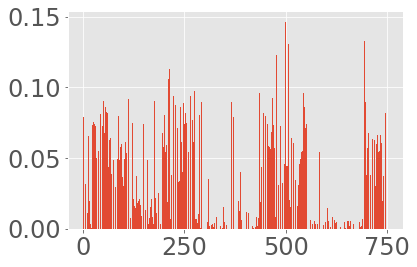

In [15]:
plot_score(fs)

In [16]:
print(shared_descriptors_fs.shape, only2c9_descriptors_fs.shape)

(9420, 450) (2813, 450)


### 5.2) Fingerprint features selection

In this part we want to select the fingerprint features that are very representative of the molecule activity.
To do so, the the mutual information classification is used for the descriptor selection, for coherence with the descriptors.

However, in this case it is not mandatory to use the mutual information classification, therefore, we could also use the chi2 test.

Moreover, as the fingerprint are "boolean descriptors", we could also implement a variance threshold, as it has been previously done in other studies (Joan).

In [17]:
shared_features_fs, only2c9_features_fs, fs_morgan = select_features_univar(features_shared, labels_2c9, features_only_2c9, score_func=mutual_info_classif, percentile = percetile_fingerprint)

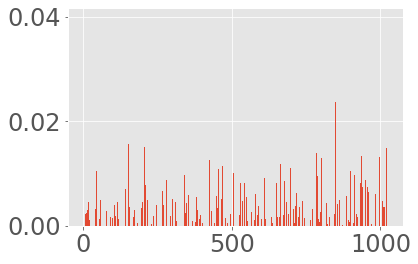

In [18]:
plot_score(fs_morgan)

In [19]:
print(shared_features_fs.shape, only2c9_features_fs.shape)

(9420, 410) (2813, 410)


## 6) Preparing the trainig, validatio and test sets

### 6.1) Joining selected descriptors and fingerprints



Now we have to join both data into a df that will be used to train and evaluate a NN.

In [20]:
concatenated_shared = np.concatenate([shared_descriptors_fs, shared_features_fs], axis=1)
concatenated_only2c9 = np.concatenate([only2c9_descriptors_fs, only2c9_features_fs], axis=1)

In [21]:
concatenated_shared.shape[1]==concatenated_only2c9.shape[1]

True

### 6.2) Splitting the data

We will split the data and reduce the training set to:

- 375 examples for the training set from the shared dataset (`concatenated_shared`)
- 125 examples for the validation set from the shared dataset (`concatenated_shared`)
- 125 examples for the test set from the only2c9 dataset (`concatenated_only2c9`)

In [154]:
dataset_size = 500                  # training + validation sets
trainset_size = int(0.75 * dataset_size)
testset_size = int(0.25 * dataset_size)  # To have the same #examples in the test and validation set (Assuming that the mini_dataset will be split 75% train/25%val.)
m_only_2c9 = concatenated_only2c9.shape[0] # number of examples in the features_only_2c9
np.random.seed(3)

permutation_only_2c9 = list(np.random.permutation(m_only_2c9))
shuffled_testing_2c9_data = concatenated_only2c9[permutation_only_2c9,:]
shuffled_labels_testing_2c9 = labels_testing_2c9[permutation_only_2c9]

mini_testing_2c9_data = shuffled_testing_2c9_data[:testset_size,:]
mini_labels_testing_2c9_data = shuffled_labels_testing_2c9[:testset_size].reshape(testset_size,1)

print(mini_testing_2c9_data.shape, mini_labels_testing_2c9_data.shape)

(125, 860) (125, 1)


(375, 860) (125, 860) (375,) (125,)


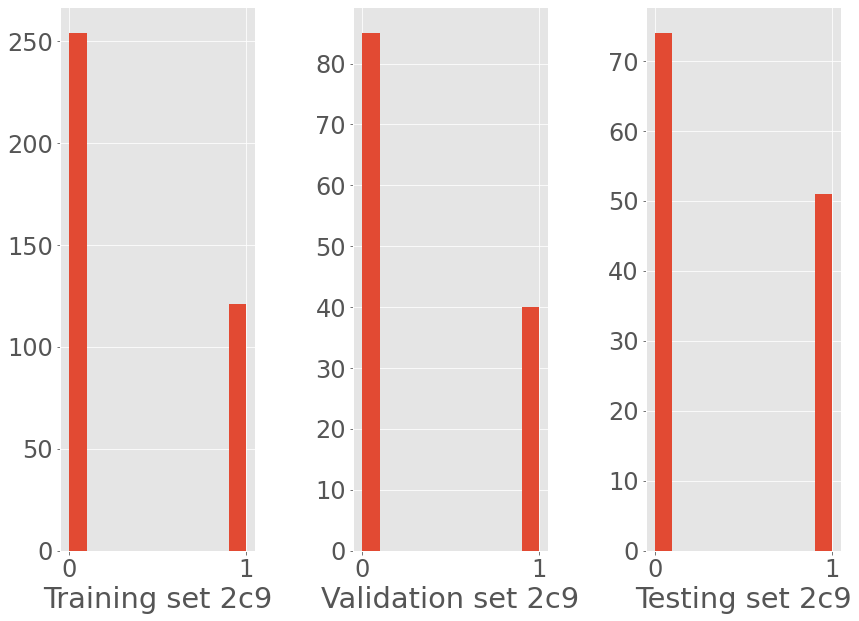

In [155]:
train_data, val_data, train_labels, val_labels = train_test_split(concatenated_shared, labels_2c9, train_size=trainset_size, test_size=testset_size, stratify=labels_2c9, random_state=2)
print(train_data.shape, val_data.shape, train_labels.shape, val_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(val_labels)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(mini_labels_testing_2c9_data)
ax[2].set_xlabel("Testing set 2c9")
plt.subplots_adjust(wspace=0.5)

In [156]:
train_data = np.asarray(train_data).astype(np.float32)
val_data = np.asarray(val_data).astype(np.float32)
mini_testing_2c9_data = np.asarray(mini_testing_2c9_data).astype(np.float32)

Since we have an unbalanced dataset, we will attribute to each class a weight.
In this way we simulate having the same number of active and inactive cases.

In [157]:
class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1
 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1
 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0
 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1
 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [86]:
class_weight

{0: 0.7375328083989501, 1: 1.5524861878453038}

## 7) Neural network

In [77]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc
    
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
          print("\n Reached 80% accuracy on training set so cancelling training!")
          self.model.stop_training = True
        if(logs.get('val_accuracy')>0.80):
          print("\n Reached 70% accuracy on validation set so cancelling training!")
          self.model.stop_training = True

In [78]:
#import datetime


layers_dim = [train_data.shape[1], 10, 10, 10, 1]
lr = 0.001
dropout = 0.2
optimizer = 'adam'
L2 = 0.001

callbacks = myCallback()

#os.makedirs("logs/fit/morgan_mordred_Mix_feature_selection", exist_ok=True)
#log_dir = "logs/fit/morgan_mordred_Mix_feature_selection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#model_small_dataset =generate_model(layers_dim, lr, dropout, optimizer, L2)
#model_small_dataset.summary()


history = model_small_dataset.fit(
      train_data, train_labels,
      epochs=25,
      verbose=2,
      #validation_data = (mini_testing_2c9_data, mini_labels_testing_2c9_data)
      validation_data = (val_data, val_labels),
      #callbacks=[tensorboard_callback],
      class_weight=class_weight
      )

Train on 1500 samples, validate on 500 samples
Epoch 1/25
1500/1500 - 1s - loss: 28136.7081 - accuracy: 0.3353 - precision_6: 0.3233 - recall_6: 0.9772 - val_loss: 0.7837 - val_accuracy: 0.3220 - val_precision_6: 0.3220 - val_recall_6: 1.0000
Epoch 2/25
1500/1500 - 1s - loss: 0.8808 - accuracy: 0.3313 - precision_6: 0.3205 - recall_6: 0.9647 - val_loss: 0.7836 - val_accuracy: 0.3220 - val_precision_6: 0.3220 - val_recall_6: 1.0000
Epoch 3/25
1500/1500 - 1s - loss: 83521.1388 - accuracy: 0.3380 - precision_6: 0.3232 - recall_6: 0.9689 - val_loss: 0.7837 - val_accuracy: 0.3220 - val_precision_6: 0.3220 - val_recall_6: 1.0000
Epoch 4/25
1500/1500 - 2s - loss: 282411.2002 - accuracy: 0.3280 - precision_6: 0.3208 - recall_6: 0.9772 - val_loss: 0.7839 - val_accuracy: 0.3220 - val_precision_6: 0.3220 - val_recall_6: 1.0000
Epoch 5/25
1500/1500 - 1s - loss: 1302.3798 - accuracy: 0.3253 - precision_6: 0.3207 - recall_6: 0.9834 - val_loss: 0.7840 - val_accuracy: 0.3220 - val_precision_6: 0.3220 

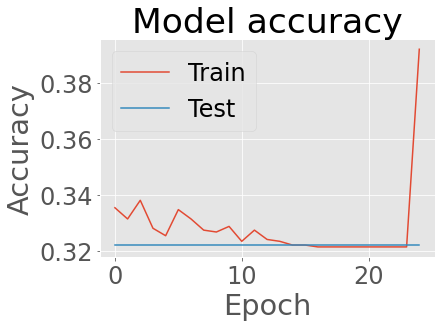

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

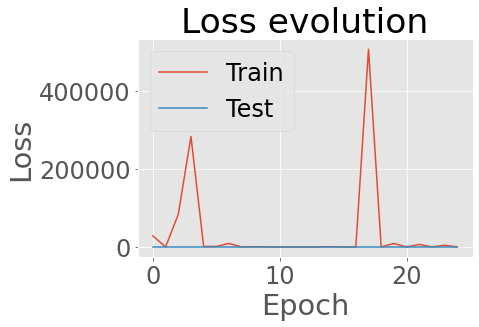

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

/Users/Anna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


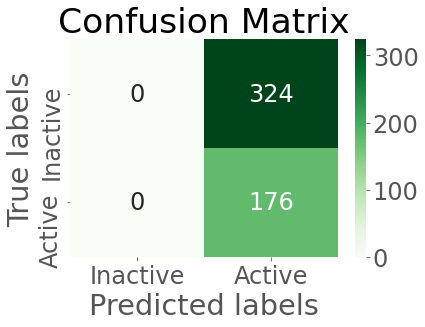

In [81]:
"""
concatenated_only2c9 = np.asarray(concatenated_only2c9).astype(np.float32)

results = model_small_dataset.evaluate(concatenated_only2c9, labels_testing_2c9)
predictions = model_small_dataset.predict(concatenated_only2c9)
print_metrics(predictions, labels_testing_2c9)
plot_confusion(predictions, labels_testing_2c9)

"""

results = model_small_dataset.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data)
predictions = model_small_dataset.predict(mini_testing_2c9_data)
print_metrics(predictions, mini_labels_testing_2c9_data)
plot_confusion(predictions, mini_labels_testing_2c9_data)


In [ ]:
%tensorboard --logdir logs/fit/morgan_mordred_Mix_feature_selection

### 7.1.) Tunning Hyperparameters

No funciona la meva versió (la que està com a markdown)

#HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(2, 6))))
#per ara sense hidden layers com a hyperparametre. Primer mirarem com fer-ho amb diferents capes.
HP_NEURONS_1 = hp.HParam("neurons_1", hp.Discrete(list(range(5, 66, 5))))
HP_NEURONS_2 = hp.HParam("neurons_2", hp.Discrete(list(range(5, 66, 5))))
HP_NEURONS_3 = hp.HParam("neurons_3", hp.Discrete(list(range(5, 66, 5))))
HP_NEURONS_4 = hp.HParam("neurons_4", hp.Discrete(list(range(5, 66, 5))))
HP_NEURONS_5 = hp.HParam("neurons_5", hp.Discrete(list(range(5, 66, 5))))

HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'adagrad','RMSprop'])) # 'sgd'
HP_L2 = hp.HParam('l2_regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.0001, 0.001, 0.01, 0.1, 1.0]))

os.makedirs("hyperparameters_tunning/morgan_mordred_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_mordred_feature_selection/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_NEURONS_1, HP_NEURONS_2, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR], # 2 hid_layers by the moment
                      metrics=[hp.Metric("accuracy", display_name='Accuracy')])#, hp.Metric('precision', display_name='Precision'),hp.Metric('recall', display_name='Recall')])
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate = hparams[HP_LR])
    #elif hparams[HP_OPTIMIZER] == "sgd":
    #    return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT]), 
                       tf.keras.layers.Dense(hparams[HP_NEURONS_1], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu'),
                       tf.keras.layers.Dropout(hparams[HP_DROPOUT]), 
                       tf.keras.layers.Dense(hparams[HP_NEURONS_2], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu'),
                       tf.keras.layers.Dropout(hparams[HP_DROPOUT]), 
                       tf.keras.layers.Dense(hparams[HP_NEURONS_3], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu')
                      ]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(train_data.shape[1], activation='relu', input_shape=(train_data.shape[1],))] +
        internal_layers + [tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model.fit(train_data, train_labels, epochs=5, verbose=2)
    results = model.evaluate(val_data, val_labels)
    #_, results = model.evaluate(val_data, val_labels)
    return results

def run(run_dir, hparams):
      if os.path.exists(run_dir):
        return
      with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar("accuracy", accuracy, step=1)

hyperparam_tunning =True

if hyperparam_tunning:
    session_num = 0
    total_runs=5
    #total_runs = len(HP_NEURONS_1.domain.values)*len(HP_NEURONS_2.domain.values)*len([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value])*len(HP_OPTIMIZER.domain.values)*len([HP_L2.domain.min_value, HP_L2.domain.max_value])*len(HP_LR.domain.values)
    looping = list(product(HP_NEURONS_1.domain.values, HP_NEURONS_2.domain.values, HP_NEURONS_3.domain.values,[HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values))
    random.shuffle(looping)
    for neurons_1, neurons_2, neurons_3, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS_1: neurons_1, HP_NEURONS_2: neurons_2, HP_NEURONS_3: neurons_3, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_mordred_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

In [160]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([i for i in range(10,151,20)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))
N_BITS = train_data.shape[1]
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(train_data, train_labels, epochs=5, verbose=2, class_weight=class_weight)
    _, results = model.evaluate(val_data, val_labels, verbose=0)                                                                                                
    _, results_val = model.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data, verbose=0)
    return results, results_val 


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, accuracy_val = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)
    tf.summary.scalar("accuracy_val", accuracy_val, step=1)

In [161]:
os.makedirs("hyperparameters_tunning/morgan_mordred_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_mordred_feature_selection').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy'), hp.Metric("accuracy_val", display_name="Validation_accuracy")]) 


if hyperparam_tunning:
    session_num = 0
    looping = list(product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values,[HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values))
    random.shuffle(looping)
    #looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    total_runs = len(list(looping))
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_mordred_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0 of 3360
{'neurons': 50, 'hidden_layers': 9, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Train on 375 samples
Epoch 1/5
375/375 - 9s - loss: nan - accuracy: 0.6427
Epoch 2/5
375/375 - 1s - loss: nan - accuracy: 0.6773
Epoch 3/5
375/375 - 0s - loss: nan - accuracy: 0.6773
Epoch 4/5
375/375 - 1s - loss: nan - accuracy: 0.6773
Epoch 5/5
375/375 - 1s - loss: nan - accuracy: 0.6773
---Starting trial: run_1 of 3360
{'neurons': 70, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Train on 375 samples
Epoch 1/5
375/375 - 6s - loss: nan - accuracy: 0.6533
Epoch 2/5
375/375 - 1s - loss: nan - accuracy: 0.6773
Epoch 3/5
375/375 - 1s - loss: nan - accuracy: 0.6773
Epoch 4/5
375/375 - 0s - loss: nan - accuracy: 0.6773
Epoch 5/5
375/375 - 1s - loss: nan - accuracy: 0.6773
---Starting trial: run_2 of 3360
{'neurons': 90, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 

KeyboardInterrupt: 

In [162]:
%tensorboard --logdir hyperparameters_tunning/morgan_mordred_feature_selection/logs/hparam_tuning/

In [ ]:
looping = product(HP_NEURONS_1.domain.values, HP_NEURONS_2.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values, repeat=2)
type(looping)
print(list(looping))

In [58]:
loop = random.shuffle(list(looping))
print(loop)

KeyboardInterrupt: 

**To do:** 

- Intentar fer funcionar el for de manera random amb itertools
- Fer els hyperparameters selection
- Posar precisio i recall a les metric del hp


In [38]:
import random

x=[1,2,3]
y=['a','b','c']
z=[10,20]
looping = list(product(x,y,z))
print(looping)
random.shuffle(looping)
print(looping)
def foo(x,y,z):
    print(x,y,z)


[(1, 'a', 10), (1, 'a', 20), (1, 'b', 10), (1, 'b', 20), (1, 'c', 10), (1, 'c', 20), (2, 'a', 10), (2, 'a', 20), (2, 'b', 10), (2, 'b', 20), (2, 'c', 10), (2, 'c', 20), (3, 'a', 10), (3, 'a', 20), (3, 'b', 10), (3, 'b', 20), (3, 'c', 10), (3, 'c', 20)]
[(1, 'c', 10), (3, 'c', 10), (1, 'b', 10), (3, 'b', 20), (2, 'a', 10), (2, 'b', 20), (2, 'a', 20), (1, 'c', 20), (2, 'c', 10), (2, 'b', 10), (1, 'a', 10), (3, 'a', 20), (3, 'a', 10), (1, 'b', 20), (2, 'c', 20), (1, 'a', 20), (3, 'b', 10), (3, 'c', 20)]


In [32]:
for comb in aa:
    foo(*comb)

1 3 0
1 3 1
1 4 0
1 4 1
2 3 0
2 3 1
2 4 0
2 4 1
3 3 0
3 3 1
3 4 0
3 4 1


In [9]:
print(list(looping))

[]


In [36]:
aa=list(product([1,2,3],[3,4],[0,1]))
print(aa)
random.shuffle(aa)
print(aa)

[(1, 3, 0), (1, 3, 1), (1, 4, 0), (1, 4, 1), (2, 3, 0), (2, 3, 1), (2, 4, 0), (2, 4, 1), (3, 3, 0), (3, 3, 1), (3, 4, 0), (3, 4, 1)]
[(2, 4, 1), (2, 4, 0), (3, 3, 0), (3, 4, 1), (3, 3, 1), (2, 3, 1), (1, 3, 1), (1, 4, 1), (1, 4, 0), (2, 3, 0), (1, 3, 0), (3, 4, 0)]


In [94]:
looping = list(product([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values))
#print(looping)

In [95]:
random.shuffle(looping)

In [96]:
print(looping)

[(0.2, 'RMSprop', 0.01, 0.01), (0.5, 'adam', 0.001, 0.0001), (0.5, 'sgd', 0.01, 0.01), (0.2, 'sgd', 0.01, 0.0001), (0.2, 'sgd', 0.01, 0.01), (0.2, 'RMSprop', 0.01, 1.0), (0.2, 'sgd', 0.001, 1.0), (0.5, 'RMSprop', 0.001, 0.01), (0.2, 'sgd', 0.01, 0.1), (0.5, 'sgd', 0.01, 1.0), (0.5, 'sgd', 0.001, 0.1), (0.5, 'RMSprop', 0.001, 1.0), (0.5, 'RMSprop', 0.01, 0.1), (0.5, 'RMSprop', 0.01, 0.01), (0.5, 'sgd', 0.001, 0.001), (0.2, 'adam', 0.001, 0.0001), (0.5, 'RMSprop', 0.01, 0.001), (0.2, 'adam', 0.01, 1.0), (0.2, 'adam', 0.001, 0.01), (0.2, 'adam', 0.01, 0.0001), (0.5, 'adam', 0.01, 0.1), (0.5, 'adam', 0.01, 1.0), (0.5, 'RMSprop', 0.01, 0.0001), (0.5, 'sgd', 0.001, 0.0001), (0.5, 'adam', 0.01, 0.01), (0.2, 'RMSprop', 0.01, 0.0001), (0.5, 'sgd', 0.01, 0.001), (0.2, 'adam', 0.01, 0.1), (0.2, 'adam', 0.001, 0.1), (0.5, 'RMSprop', 0.001, 0.1), (0.2, 'adam', 0.01, 0.01), (0.2, 'RMSprop', 0.001, 0.1), (0.2, 'sgd', 0.001, 0.0001), (0.5, 'RMSprop', 0.01, 1.0), (0.2, 'RMSprop', 0.001, 0.001), (0.2, '